## FROM Tutorial: https://www.tensorflow.org/tutorials/structured_data/time_series

## (sources Chollet's book "Deep Learning with Python" (6.3))

## overs Univariate time series first, then Multivariate

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [23]:
### Download Dataset:
### Default Keras Save Location: C:\Users\Administrator\.keras\datasets

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 4s 0us/step


In [2]:
# df = pd.read_csv(csv_path)


df = pd.read_csv("data\jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


_______________

"As you can see above, an observation is recorded every 10 mintues. 
This means that, for a single hour, you will have 6 observations. 
Similarly, a single day will contain 144 (6x24) observations.

Given a specific time, let's say you want to predict the temperature 6 hours in the future. 
In order to make this prediction, you choose to use 5 days of observations. 
Thus, you would create a window containing the last 720(5x144) observations to train the model. 
Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. 
The parameter history_size is the size of the past window of information. 
The target_size is how far in the future does the model need to learn to predict. 
The target_size is the label that needs to be predicted."

In [3]:
# Create function to feed data later
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

_In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data._

In [4]:
TRAIN_SPLIT = 300000

# Setting seed to ensure reproducibility 
# (will always reproduce the same 'random' values with this seed)
tf.random.set_seed(13)


_______________

# Part 1: Forecast a univariate time series
_First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future._

_Let's first extract only the temperature from the dataset._

In [5]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025200048C48>],
      dtype=object)

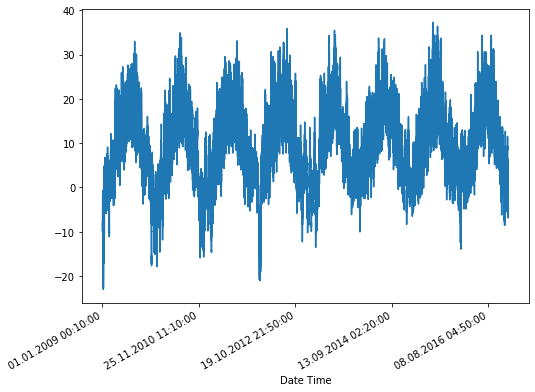

In [6]:
# Plot to see how data looks over time

uni_data.plot(subplots=True)


In [7]:
# Convert dataframe to numpy array:
# (This only converts the values, not the index, so it will leave out the dates)
uni_data = uni_data.values

In [8]:
print(uni_data.shape)

uni_data


(420551,)


array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

----------------------

It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature._

_You could also use a tf.keras.utils.normalize method that rescales the values into a range of [0,1].


In [9]:
# normalizing using the mean and std method
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


______________

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step.

In [10]:
# past 20 values leading to the 0'th value to be predicted:
univariate_past_history = 20
univariate_future_target = 0

# Use the defined function to feed the data splits
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


---------------

Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

In [13]:

# Create a Dynamic plot script, to be resused for all sets  (..... jezuz)

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'X:\\Anaconda\\envs\\TensorFlow\\lib\\site-packages\\matplotlib\\pyplot.py'>

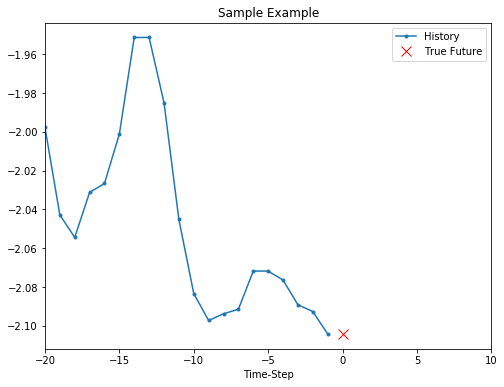

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

_______________

Baseline

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [15]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'X:\\Anaconda\\envs\\TensorFlow\\lib\\site-packages\\matplotlib\\pyplot.py'>

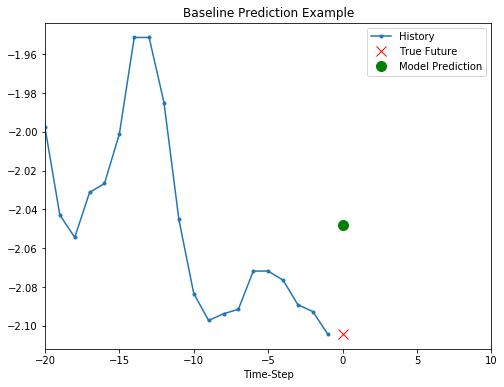

In [17]:
# plot using the dynamic function created above:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

________

Goal is to beat this baseline prediction

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the RNN tutorial. In this tutorial, you will use a specialized RNN layer called Long Short Term Memory (LSTM)

Let's now use tf.data to shuffle, batch, and cache the dataset.


In [19]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [25]:

# The following visualisation should help you understand how the data is represented after batching.


from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.tensorflow.org/tutorials/structured_data/images/time_series.png", width=400, height=400)


You will see the LSTM requires the input shape of the data it is being given.


In [26]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model.


In [27]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


______________
Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.



In [28]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2932 - val_loss: 0.0696
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0703 - val_loss: 0.0272
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0387 - val_loss: 0.0227
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0362 - val_loss: 0.0204
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0242 - val_loss: 0.0192
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0263 - val_loss: 0.0183
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0239 - val_loss: 0.0177
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0228 - val_loss: 0.0166
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0221 - val_loss: 0.0160
Epoch 10/10
200/200 [===========================

______________

Predict using the simple LSTM model

Now that you have trained your simple LSTM, let's try and make a few predictions.

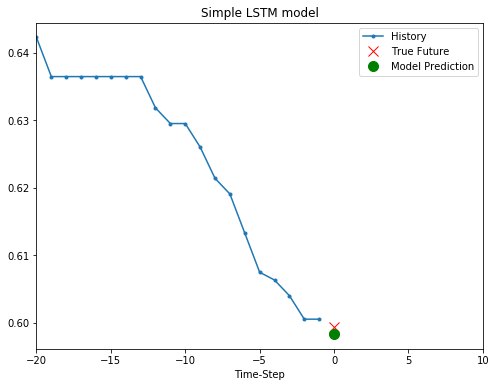

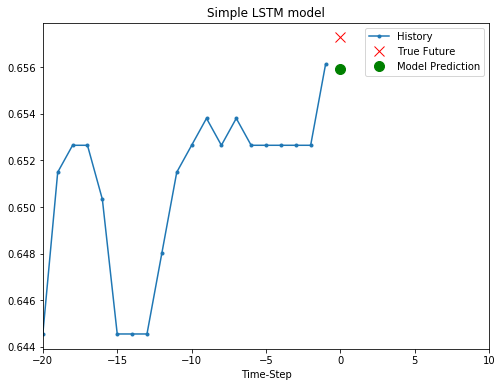

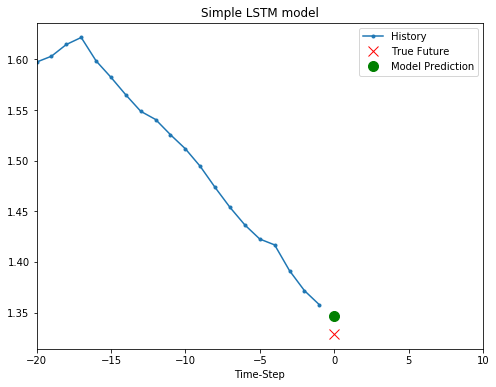

In [29]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

__________________


__________________


# Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density.

To use more features, add their names to this list.

In [32]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [33]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025208D679C8>,
      dtype=object)

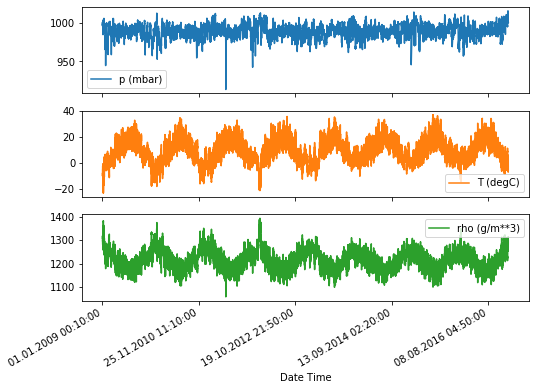

In [34]:
features.plot(subplots=True)


_________

As mentioned, the first step will be to standardize the dataset using the mean and standard deviation of the training data.


In [36]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std


### Single step model

In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [38]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

______

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.



In [39]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [40]:

# look at a single data point:
print ('Single window of past history : {}'.format(x_train_single[0].shape))


Single window of past history : (120, 3)


__________

Build RNN

In [41]:
# shuffle, batch, and cache the dataset.

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [42]:
# RNN

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [43]:
# Sample Prediction:

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [44]:
# Train the model: ( this takes a long time !! )
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 36s 181ms/step - loss: 0.2978 - val_loss: 0.2584
Epoch 2/10
200/200 [==============================] - 41s 206ms/step - loss: 0.2612 - val_loss: 0.2438
Epoch 3/10
200/200 [==============================] - 50s 250ms/step - loss: 0.2594 - val_loss: 0.2444
Epoch 4/10
200/200 [==============================] - 58s 290ms/step - loss: 0.2570 - val_loss: 0.2402
Epoch 5/10
200/200 [==============================] - 67s 335ms/step - loss: 0.2247 - val_loss: 0.2338
Epoch 6/10
200/200 [==============================] - 80s 398ms/step - loss: 0.2394 - val_loss: 0.2673
Epoch 7/10
200/200 [==============================] - 82s 408ms/step - loss: 0.2416 - val_loss: 0.2513
Epoch 8/10
200/200 [==============================] - 84s 419ms/step - loss: 0.2404 - val_loss: 0.2468
Epoch 9/10
200/200 [==============================] - 85s 426ms/step - loss: 0.2409 - val_loss: 0.2441
Epoch 10/10
200/200 [=========

In [45]:
### plot loss

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

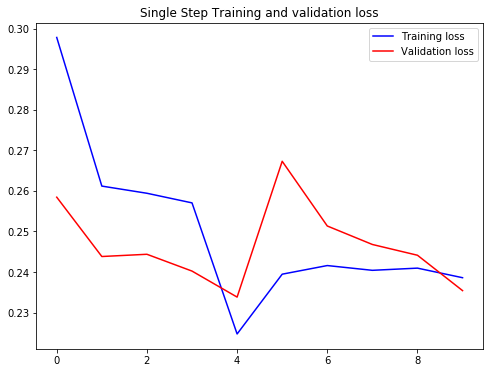

In [46]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

______________________


Predict a single step future

Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction).

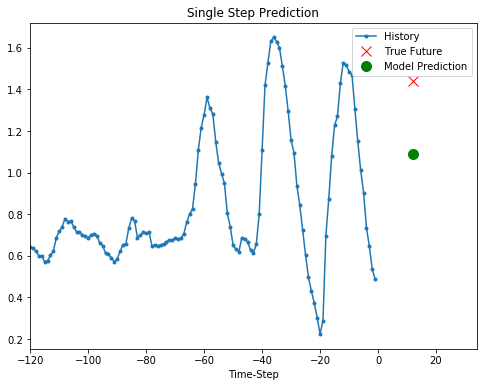

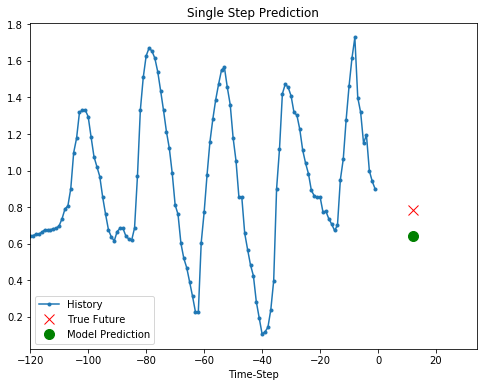

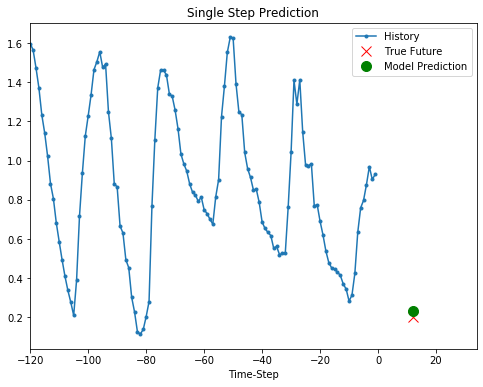

In [47]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


________________


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.



In [48]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

______

Let's check out a sample data-point.


In [49]:

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [50]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

_________

Plotting a sample data-point.



In [52]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

_________

In this plot and subsequent similar plots, the history and the future data are sampled every hour.



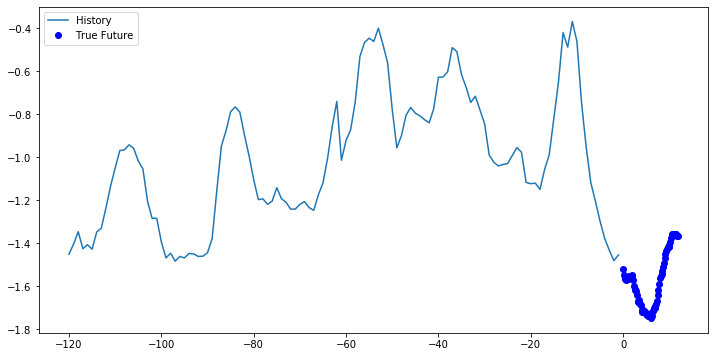

In [53]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

__________

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.



In [54]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

__________


Let's see how the model predicts before it trains.



In [55]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [56]:
# Train: (takes even longer  !! )

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 118s 588ms/step - loss: 1.0768 - val_loss: 0.4469
Epoch 2/10
200/200 [==============================] - 125s 623ms/step - loss: 0.6197 - val_loss: 0.4006
Epoch 3/10
200/200 [==============================] - 136s 679ms/step - loss: 0.4845 - val_loss: 0.3672
Epoch 4/10
200/200 [==============================] - 151s 755ms/step - loss: 0.4060 - val_loss: 0.2950
Epoch 5/10
200/200 [==============================] - 166s 832ms/step - loss: 0.3163 - val_loss: 0.2745
Epoch 6/10
200/200 [==============================] - 181s 903ms/step - loss: 0.3162 - val_loss: 0.2583
Epoch 7/10
200/200 [==============================] - 181s 907ms/step - loss: 0.2499 - val_loss: 0.2371
Epoch 8/10
200/200 [==============================] - 185s 925ms/step - loss: 0.2258 - val_loss: 0.2154
Epoch 9/10
200/200 [==============================] - 183s 916ms/step - loss: 0.2206 - val_loss: 0.2013
Epoch 10/10
200/200 [

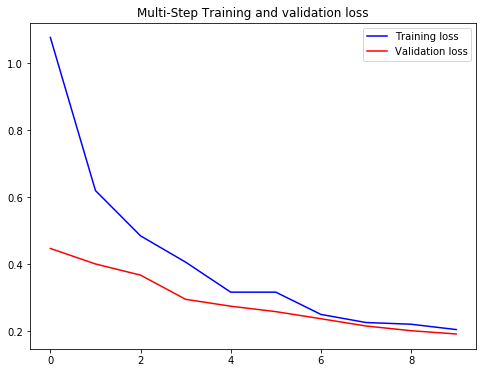

In [57]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


______________

Predict a multi-step future

Let's now have a look at how well your network has learnt to predict the future.

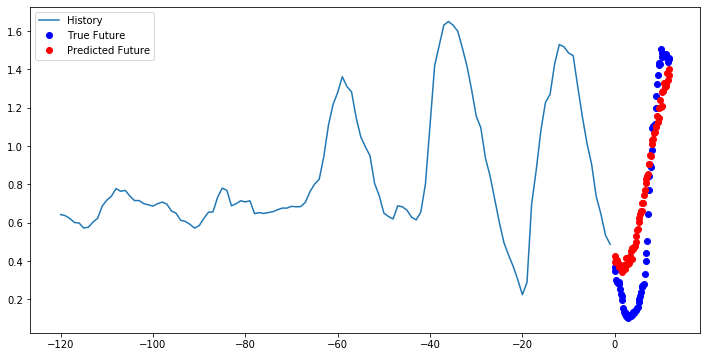

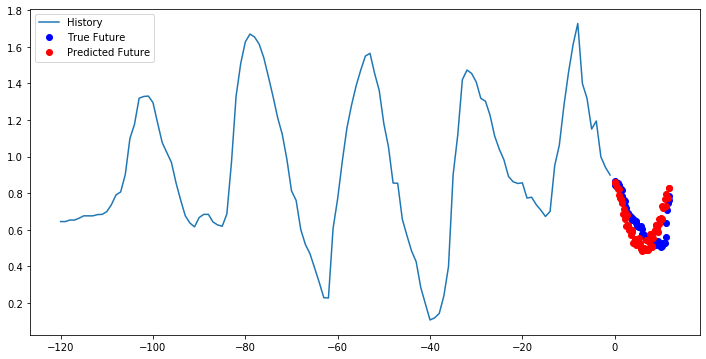

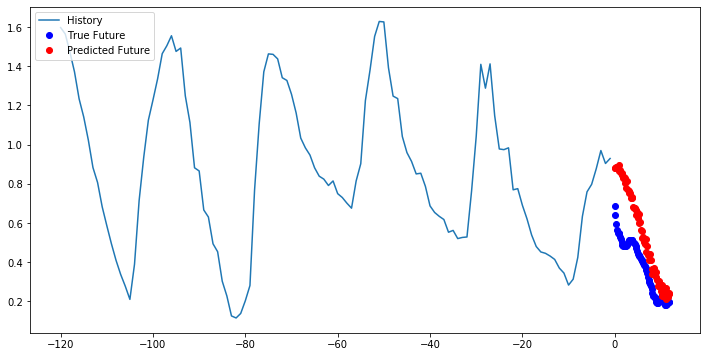

In [58]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])